## Import libraries

In [40]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
#from sklearn.model_selection import train_test_split

## Generate image dataset

In [9]:
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/Brain Cancer/Training",
    validation_split = 0.2,
    subset = "both",
    seed = 1337,
    image_size = (180, 180),
    batch_size = 128,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/Brain Cancer/Testing",
    image_size = (180, 180),
    batch_size = 128,
    shuffle = False
)

class_names = os.listdir("dataset/Brain Cancer/Training")

Found 6000 files belonging to 3 classes.
Using 4800 files for training.
Using 1200 files for validation.
Found 1500 files belonging to 3 classes.


## Visualize the data

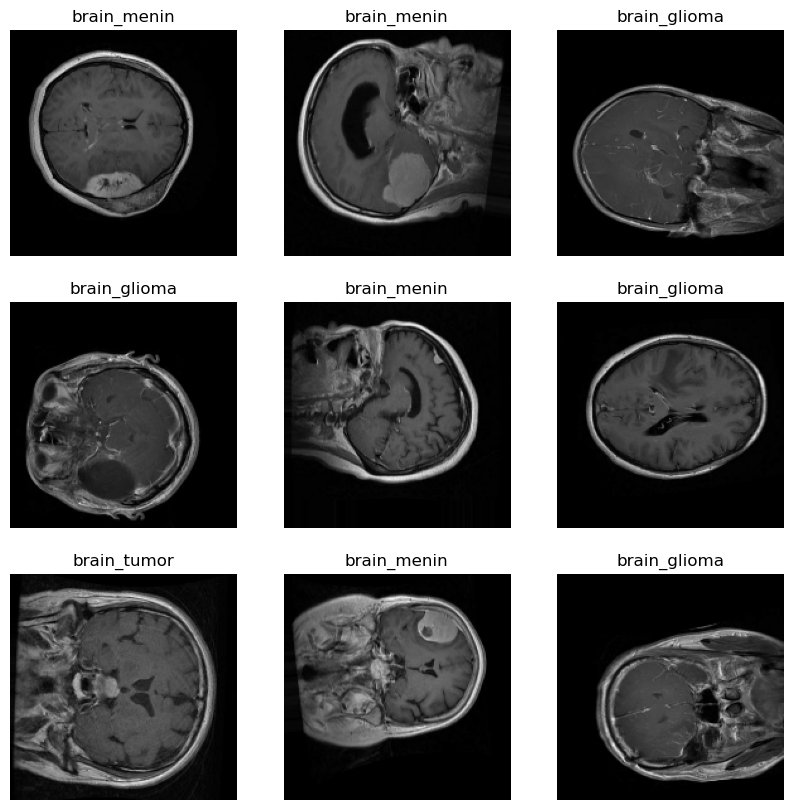

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Standardize the data

In [6]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.96431285


## Build the model 

In [7]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## Compile the model

In [8]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

## Model Summary

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 16)       

## Train the model

In [10]:
cnn_model = model.fit(train_ds, validation_data = val_ds, epochs = 10)

Epoch 1/10
38/38 [==============================] - 515s 12s/step - loss: 0.8373 - accuracy: 0.5790 - val_loss: 0.6912 - val_accuracy: 0.6633
Epoch 2/10
38/38 [==============================] - 354s 9s/step - loss: 0.6490 - accuracy: 0.7181 - val_loss: 0.5497 - val_accuracy: 0.7700
Epoch 3/10
38/38 [==============================] - 352s 9s/step - loss: 0.5552 - accuracy: 0.7694 - val_loss: 0.5076 - val_accuracy: 0.7967
Epoch 4/10
38/38 [==============================] - 284s 7s/step - loss: 0.4973 - accuracy: 0.7954 - val_loss: 0.5223 - val_accuracy: 0.7692
Epoch 5/10
38/38 [==============================] - 328s 8s/step - loss: 0.4334 - accuracy: 0.8248 - val_loss: 0.4365 - val_accuracy: 0.8275
Epoch 6/10
38/38 [==============================] - 322s 8s/step - loss: 0.3795 - accuracy: 0.8540 - val_loss: 0.4024 - val_accuracy: 0.8442
Epoch 7/10
38/38 [==============================] - 342s 9s/step - loss: 0.3193 - accuracy: 0.8840 - val_loss: 0.3838 - val_accuracy: 0.8533
Epoch 8/10
3

## Save the model

In [11]:
model.save("models/brain_cancer_model.h5")

## Load the model

In [7]:
model = load_model("models/brain_cancer_model.h5")

## Visualize training results

In [5]:
acc = cnn_model.history['accuracy']
val_acc = cnn_model.history['val_accuracy']

loss = cnn_model.history['loss']
val_loss = cnn_model.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

TypeError: 'NoneType' object is not subscriptable

## Predict on new data

In [12]:
image_url = "dataset/Brain Cancer/Testing/brain_menin/brain_menin_2514.jpg"

img = tf.keras.utils.load_img(
    image_url, target_size = (180, 180)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions[0])
print(len(predictions))
print("This image is most likely a {} with a {:.2f} percent confidence"
      .format(class_names[np.argmax(score)], 100 * np.max(score))
     )
predictions


12/12 [==============================] - 65s 5s/step
1500
This image is most likely a brain_glioma with a 97.52 percent confidence


array([[ 3.5674312 , -0.3335556 , -1.6974343 ],
       [ 2.1656206 ,  3.8830361 , -3.34582   ],
       [ 4.5424285 , -0.26872072, -2.7384346 ],
       ...,
       [-4.775129  ,  2.994433  ,  2.7561316 ],
       [-5.7785177 ,  0.49760962,  5.349471  ],
       [-4.012231  ,  1.7094132 ,  3.0054872 ]], dtype=float32)

## Get all predictions in an array

In [62]:
#Get the results in an array
y_predict = []
for i in range(len(predictions)):
    score = tf.nn.softmax(predictions[i])
    class_name = [np.argmax(score)]
    y_predict.append(class_name)

## Get actual class names

In [68]:
dataset_path = "dataset/Brain Cancer/Testing/"
names = os.listdir("dataset/Brain Cancer/Testing")
print(names)

y_test = []
for i in range(len(class_names)):
    classes = os.listdir(dataset_path+class_names[i])
    for j in range(len(classes)):
        y_test.append(i)

print(len(y_test))

['brain_glioma', 'brain_menin', 'brain_tumor']
1500


## Evaluate performance metrics

In [64]:
#print(classification_report(y_test, y_predict, target_names=class_names))
accuracy = metrics.accuracy_score(y_test, y_predict)
precision = metrics.precision_score(y_test, y_predict, average = "macro")
recall = metrics.recall_score(y_test, y_predict, average = "macro")
f1_score = metrics.f1_score(y_test, y_predict, average = "macro")

print("Accuracy = " + str(accuracy))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 score = " + str(f1_score))

Accuracy = 0.8393333333333334
Precision = 0.8599407231482702
Recall = 0.8393333333333334
F1 score = 0.8416018667099013


## Confusion Matrix

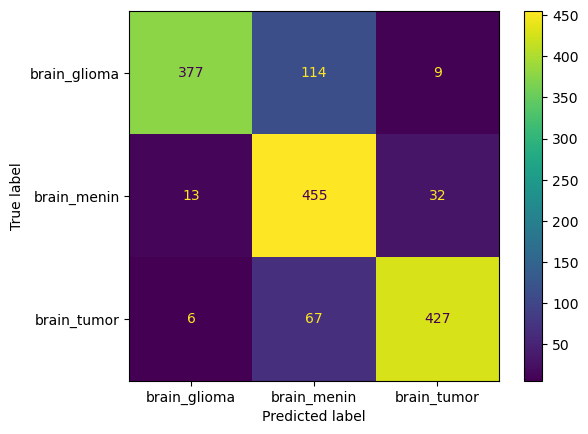

In [65]:
confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)
cm_display.plot()
plt.show()

## ROC curve